# Importing Necessarry Libraries

In [1]:
from dateutil.parser import parse
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense

from __future__ import print_function
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

# selecting plot style
plt.style.use('ggplot')
from matplotlib.dates import DateFormatter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

Dataset




In [3]:
Dataset =  pd.read_csv('/content/drive/MyDrive/Data_set/FloodPredictionData/Level sensor 1 - Namal Dam.csv',parse_dates=['Date_and_Time'],index_col=0)
Dataset

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage
Date_and_Time,,,,
2020-11-04 15:40:00,1166.732802,18.9,0.0,53.1
2020-11-04 15:50:00,1166.726240,18.1,0.0,53.1
2020-11-04 16:00:00,1166.706554,18.9,0.0,53.1
2020-11-04 16:10:00,1166.709835,18.8,0.0,53.1
2020-11-04 16:20:00,1166.709835,18.6,0.0,53.1
...,...,...,...,...
2021-11-04 04:10:00,1159.196345,13.0,0.0,86.0
2021-11-04 04:20:00,1159.202907,13.9,0.0,86.0
2021-11-04 04:30:00,1159.183221,13.8,0.0,87.0


In [5]:
print(Dataset['Lake_water_level_in_ft'].max())
print(Dataset['Lake_water_level_in_ft'].min())

print(Dataset['Temperature_in_degree_celcius'].max())
print(Dataset['Temperature_in_degree_celcius'].min())

print(Dataset['Daily_accumulative_rain_in_mm'].max())
print(Dataset['Daily_accumulative_rain_in_mm'].min())

print(Dataset['Relative_humidity_percentage'].max())
print(Dataset['Relative_humidity_percentage'].min())

1167.9074
1150.531224
44.5
1.0
54.72
-0.024
99.0
14.0


# Global Settings

In [8]:
Min_each_col_arr = [1150.531224,1.0,-0.024,14.0] #Defining the minimum threshold 
Max_each_col_arr = [1167.9074,44.5,54.72,99.0] #Defining the maximum threshold
Min_each_col = pd.Series(Min_each_col_arr, index=['Lake_water_level_in_ft','Temperature_in_degree_celcius','Daily_accumulative_rain_in_mm','Relative_humidity_percentage'])
Max_each_col = pd.Series(Max_each_col_arr, index=['Lake_water_level_in_ft','Temperature_in_degree_celcius','Daily_accumulative_rain_in_mm','Relative_humidity_percentage'])



#Global Names
name_time = 'Date_and_Time'
name_lvl = 'Lake_water_level_in_ft'
name_rain = 'Daily_accumulative_rain_in_mm'
name_humid = 'Relative_humidity_percentage'
name_temp = 'Temperature_in_degree_celcius'

# Deep Learning Model using LSTM (Long-Short-Term-Memory Network) Architecture

In [27]:
cfg = {

# LSTM_layers settings

    'hidden_states_layer1' : 144,
    'hidden_states_layer2' : 72,
    'hidden_states_layer3' : 72,
    'hidden_states_layer4' : 144,
    'dropout' : 0.2,    
    'input_size' : 144,
    'num_features' : 6,
    'hl_activation' : 'elu',


#Repeat Vector Layer 
    'steps_out' : 5,

# Dense_layer settings
    
    'dense_neurons' : 6,
    'dl_activation' : 'sigmoid',


# Model_training
    'batch_size' : 10,
    'epocs' : 30,
    'learning_rate' : 1e-3,
    'optimizer' : 'adam',
    'loss_function' : 'mean_squared_error',


}

def Prediction_Model():
  model = Sequential(name ="Namal_Flood_Prediction_Model")
  model.add( LSTM(cfg['hidden_states_layer1'], activation=cfg['hl_activation'],return_sequences=True,  name = "Hidden_Layer_1"      ))
  model.add( RepeatVector (cfg['steps_out'])                                                               )
  model.add( LSTM(cfg['hidden_states_layer2'], return_sequences=True, activation= cfg['hl_activation']     ,  name = "Hidden_Layer_2"      ))
  model.add( TimeDistributed( Dense(cfg['dense_neurons'])                             ,  name = "Output_Layer"        ))
  model.compile(loss=cfg['loss_function'], optimizer=cfg['optimizer'],metrics=['accuracy'])
  

  return model

callbacks = [
             ModelCheckpoint("/content/drive/MyDrive/FYP/aggregation/cleaned/max/1hourly_max_5out_144in_4f_1f.h5", verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5, min_lr=1e-6, verbose=1),
             CSVLogger('/content/drive/MyDrive/FYP/aggregation/cleaned/max/1hourly_max_5out_144in_4f_1f.csv',separator=",", append=True),
             EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=False)
]


In [13]:
Aggregated_data = Aggregation_WD(Dataset,'H','max')
Aggregated_data

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage
Date_and_Time,,,,
2020-11-04 15:40:00,1166.732802,18.9,0.0,53.1
2020-11-04 16:40:00,1166.722959,18.5,0.0,53.1
2020-11-16 23:40:00,1160.662952,22.5,0.0,53.1
2020-11-17 00:40:00,1160.672795,22.4,0.0,53.1
2020-11-17 01:40:00,1160.672795,22.2,0.0,53.1
...,...,...,...,...
2021-11-04 00:40:00,1159.248841,15.0,0.0,86.0
2021-11-04 01:40:00,1159.235717,14.9,0.0,86.0
2021-11-04 02:40:00,1159.219312,14.5,0.0,86.0


In [14]:
new_range = [0,1]
Normalized_data  = Min_Max_Norm_WD(Aggregated_data,Min_each_col,Max_each_col,new_range)
Normalized_data

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage
Date_and_Time,,,,
2020-11-04 15:40:00,0.932402,0.411494,0.000438,0.460000
2020-11-04 16:40:00,0.931835,0.402299,0.000438,0.460000
2020-11-16 23:40:00,0.583082,0.494253,0.000438,0.460000
2020-11-17 00:40:00,0.583648,0.491954,0.000438,0.460000
2020-11-17 01:40:00,0.583648,0.487356,0.000438,0.460000
...,...,...,...,...
2021-11-04 00:40:00,0.501699,0.321839,0.000438,0.847059
2021-11-04 01:40:00,0.500944,0.319540,0.000438,0.847059
2021-11-04 02:40:00,0.500000,0.310345,0.000438,0.847059


In [16]:
dataset = Dataset.values 
scaler  = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(dataset)

array([[9.32401813e-01, 4.11494253e-01, 4.38404209e-04, 4.60000000e-01],
       [9.32024169e-01, 3.93103448e-01, 4.38404209e-04, 4.60000000e-01],
       [9.30891239e-01, 4.11494253e-01, 4.38404209e-04, 4.60000000e-01],
       ...,
       [4.97922961e-01, 2.94252874e-01, 4.38404209e-04, 8.58823529e-01],
       [5.00566465e-01, 2.91954023e-01, 4.38404209e-04, 8.58823529e-01],
       [5.01510574e-01, 2.91954023e-01, 4.38404209e-04, 8.70588235e-01]])

# Necessary Functions



1. Cleaning Data Function

In [9]:
def Clean_WD(Dataframe):
  '''

  Clean the Raw data 

  Input:
  
  Raw Dataframe  [Device Time Stamp, Cloud Time Stamp, Water Elevation (ft.), Depth (ft.), Discharge (cfs), Node ID, Measured Range, Signal Strength, Water Temp, Voltage (v)]


  Output:

  Clean_dataframe ['Date_and_Time', 'Lake_water_level_in_ft', 'Daily_accumulative_rain_in_mm' , 'Relative_humidity_percentage' , 'Temperature_in_degree_celcius']

  '''



  Data_frame = Dataframe.copy() #ceating copy of dataframe to avoid changing original dataframe

  #Delta_Time
  DT_1_MINUTE = 1
  DT_2_MINUTE = 2
  
  #Declaring Useful Columns
  TIME_COL = 'Device Time Stamp'
  DATA1_COL = 'Measured Range'
  DATA2_COL =  'Water Temp'

  #Creating empty Dataframe to which the cleaned values is to be stored
  dateAndTime = pd.DataFrame(columns = [name_time])
  LakeWaterLevel = pd.DataFrame(columns = [name_lvl])
  rain_mm = pd.DataFrame(columns = [name_rain])
  humidity = pd.DataFrame(columns = [name_humid])
  Temperature = pd.DataFrame(columns = [name_temp])

  #Extracting useful columns from the Raw dataframe
  data = Data_frame[[TIME_COL, DATA1_COL, DATA2_COL]]

  #Droping the duplicate values
  new_df = data.drop_duplicates(subset = TIME_COL , ignore_index=True)
  

  #sorting the data frame with most recent value first
  DF_sort = new_df.sort_values(by = TIME_COL ,ascending = False)

  #Separating out the Time column
  Time_df = pd.DataFrame()
  Time_df[TIME_COL] = DF_sort[TIME_COL]
 


  #for loop to go line by line on the raw data
  for i in range(2,np.size(Time_df)):

    #data corresponding to xx:x0:00 time
    if( (Time_df[TIME_COL][i].minute % 10)  == 0):


      #integrity check to see that all time_stamp entries are valid
      if( Time_df[TIME_COL][i].minute == Time_df[TIME_COL][i-1].minute - DT_1_MINUTE and  Time_df[TIME_COL][i].minute == Time_df[TIME_COL][i-2].minute - DT_2_MINUTE ):
        


        #add time data in array to be used for plotting (this is going to be the time axis)
        dateAndTime =  pd.concat([dateAndTime, pd.DataFrame(pd.Series(pd.to_datetime(Time_df[TIME_COL][i].value)),columns= [name_time])],ignore_index= True)

        
        #extract sign of temperature
        if(DF_sort[DATA2_COL][i-2] == 0):
          Sign = -1       
        else:
          Sign = 1
        
        #apply formula to get water level elevation in feet from range in mm

        if( DF_sort[DATA1_COL][i]>4500  and  DF_sort[DATA1_COL][i]<9999 ):
          LakeWaterLevel =  pd.concat([LakeWaterLevel, pd.DataFrame(pd.Series(1183 - 3.281* (DF_sort[DATA1_COL][i])/1000),columns= [name_lvl])],ignore_index= True)
        else:
          LakeWaterLevel =  pd.concat([LakeWaterLevel, pd.DataFrame(pd.Series(np.nan),columns= [name_lvl])],ignore_index= True)
        
        #log the rain data
        if( DF_sort[DATA1_COL][i-1] > -1 and DF_sort[DATA1_COL][i-1] < 500 ):
          rain_mm = pd.concat([rain_mm, pd.DataFrame(pd.Series(0.24 * (DF_sort[DATA1_COL][i-1])),columns= [name_rain])],ignore_index= True)
        else:
          rain_mm =  pd.concat([rain_mm, pd.DataFrame(pd.Series(np.nan),columns= [name_rain])],ignore_index= True)

        #log humidity data
        if( DF_sort[DATA2_COL][i-1] > 0 and DF_sort[DATA2_COL][i-1] < 1000 ):
          humidity = pd.concat([humidity, pd.DataFrame(pd.Series((DF_sort[DATA2_COL][i-1])/10),columns= [name_humid])],ignore_index= True)
        else:
          humidity =  pd.concat([humidity, pd.DataFrame(pd.Series(np.nan),columns= [name_humid])],ignore_index= True)

        #log the temperature
        if( (Sign * (DF_sort[DATA2_COL][i-2])) < 600 and (Sign*DF_sort[DATA2_COL][i-2]) > -250 ):
          Temperature = pd.concat([Temperature, pd.DataFrame(pd.Series( (Sign*(DF_sort[DATA2_COL][i-2]))/10 ),columns= [name_temp])],ignore_index= True)
        else:
          Temperature =  pd.concat([Temperature, pd.DataFrame(pd.Series(np.nan),columns= [name_temp])],ignore_index= True)


  #Concatinating all the columns to get single data frame
  clean_Df = pd.concat([dateAndTime,LakeWaterLevel,Temperature,rain_mm,humidity] ,axis=1)

  #Drop the rows containing nan values
  clean_df_new = clean_Df.dropna(axis=0, how='any')
  
  #sort the dataframe in ascending order w.r.t time axis
  Dataframe_clean = clean_df_new.sort_values(by = name_time ,ascending = True,ignore_index=True)

  return Dataframe_clean


2. Data Aggregation Function

In [10]:
def Aggregation_WD(Data_frame,rule,Type):
  
  """
  Makes the aggregation of dataset according to the provided rule 


  Inputs:

  Data_frame:  ['Lake_water_level_in_ft', 'Daily_accumulative_rain_in_mm' , 'Relative_humidity_percentage' , 'Temperature_in_degree_celcius'] and index_col = Date_and_Time
  
  rule: ['H' (hourly) , 'D' (daily)]  The constant can be specified like '1.5H' for 1.5 Hourly aggregation

  Type: ['mean' , 'max'] The type of aggregation (max or average)

  Outputs:

  new aggregated dataframe based on the inputs provided
  new_ dataframe ['Lake_water_level_in_ft', 'Daily_accumulative_rain_in_mm' , 'Relative_humidity_percentage' , 'Temperature_in_degree_celcius'] and index_col = Date_and_Time

  """

  df = Data_frame.copy() #create a copy of dataframe to avoid changing original dataframe
  
  new_dataframe = pd.DataFrame() #creating empty data frame in which the transformed values can be stored

  #if conditions to check for which Type of aggregation

  if(Type=='mean'):

    #for loop for mean aggregation column wise on dataframe w.r.t index col (Date_and_Time) 
    
    for column in df.columns:
      new_dataframe[column]= df[column].resample(rule,origin='start').mean()

  elif(Type=='max'):

    #for loop for max aggregation column wise on dataframe w.r.t index col (Date_and_Time)

    for column in df.columns:
      new_dataframe[column]= df[column].resample(rule,origin='start').max()
      
  else:
    print("Wrong-Type-Specified  options [ 'mean' , 'max'  ]")

  
  new_dataframe = new_dataframe.dropna(axis=0, how='any') #drop the Nan values (if exists)

  return new_dataframe

3. Normalization and Denormalization Functions

In [11]:
def Min_Max_Norm_WD(Data_frame,Min_each_col,Max_each_col,Range):
  """
  
  Normalize whole data-frame using Min_Max_Normalization

  Input:

  data-frame [Water_level,Temp,Rain,Humidity]

  Range-> [new_min , new_max]  (New range of values after normalization)
  

  Output:

  Normalized data-frame [Water_level,Temp,Rain,Humidity]
  
  """
  
  df  = Data_frame.copy() #Make Copy to avoid change the original Data Frame

  #Getting Min and Max from the user provided range 
  new_min = Range[0]
  new_max = Range[1] 

  #For loop apply normalization to each column in data-frame 
  for column in df.columns:
    df[column] = ((df[column]-Min_each_col[column])/(Max_each_col[column]-Min_each_col[column]))*(new_max-new_min) + new_min
  

  return df


def Min_Max_Denorm_WD(Data_frame,Min_each_col,Max_each_col,Range):
  """

  Inputs:

  data-frame ['Lake_water_level_in_ft', 'Daily_accumulative_rain_in_mm' , 'Relative_humidity_percentage' , 'Temperature_in_degree_celcius'] and index_col = Date_and_Time

  Min_each_col data frame [min_wlvl, min_temp, min_rain, min_humidity]
  Max_each_col data frame [max_wlvl, max_temp, max_rain, max_humidity]
  Range = [new_min, new_max]

  Output:

  Denormalized data-frame ['Lake_water_level_in_ft', 'Daily_accumulative_rain_in_mm' , 'Relative_humidity_percentage' , 'Temperature_in_degree_celcius'] and index_col = Date_and_Time


  """

  ##Getting Min and Max from the user provided range 
  new_min = Range[0]
  new_max = Range[1]

  df = Data_frame.copy() #Making copy of data-frame to avoid changing original dataframe

  #For loop to convert back from the normalized values
  for column in df.columns:
    df[column] =   (((df[column]-new_min)/(new_max-new_min))* (Max_each_col[column]-Min_each_col[column])) + Min_each_col[column]  

  return df

4. Sequence Generation Function

In [12]:

def create_dataset(dataframe, sliding_window=1):

    dataset = dataframe.values
    dataX, dataY = [], []
    for i in range(0,len(dataset)-sliding_window-1-5,5):
        a = dataset[i:(i+sliding_window), :]
        dataX.append(a)
        b = dataset[(i+sliding_window):(i+sliding_window+5),:]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def create_dataset2(dataset, sliding_window=1):

    #dataset = dataframe.values
    dataX, dataY = [], []
    for i in range(0,len(dataset)-sliding_window-1-5,5):
        a = dataset[i:(i+sliding_window), :]
        dataX.append(a)
        b = dataset[(i+sliding_window):(i+sliding_window+5),:]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

# Working

1. Loading The Data(Cleaned) 

ValueError: ignored

2. Making the hourly maximum aggregation

In [ ]:
Aggregated_data = Aggregation_WD(Dataset,'H','max')
Aggregated_data

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage,lawa_water_level_in_ft,Daily_accumulative_rain_in_mm_2
Date_and_Time,,,,,,
2021-03-31 03:40:00,1150.990564,14.1,0.0,57.0,0.689010,0.0
2021-03-31 04:40:00,1150.977440,13.5,0.0,64.0,0.669324,0.0
2021-03-31 05:40:00,1150.961035,13.6,0.0,65.0,0.669324,0.0
2021-03-31 09:40:00,1150.737927,27.3,0.0,25.0,0.374034,0.0
2021-03-31 10:40:00,1150.754332,29.5,0.0,26.0,0.374034,0.0
...,...,...,...,...,...,...
2021-10-10 03:40:00,1159.586784,23.8,0.0,83.0,0.098430,0.0
2021-10-10 04:40:00,1159.616313,22.8,0.0,84.0,0.101711,0.0
2021-10-10 05:40:00,1159.599908,22.6,0.0,86.0,6.670273,0.0


3. Normalizing the Data

In [ ]:
new_range = [0,1]
Normalized_data  = Min_Max_Norm_WD(Aggregated_data,Min_each_col,Max_each_col,new_range)
Normalized_data

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage,lawa_water_level_in_ft,Daily_accumulative_rain_in_mm_2
Date_and_Time,,,,,,
2021-03-31 03:40:00,0.274764,0.460000,0.0,0.57,0.068901,0.0
2021-03-31 04:40:00,0.274436,0.452941,0.0,0.64,0.066932,0.0
2021-03-31 05:40:00,0.274026,0.454118,0.0,0.65,0.066932,0.0
2021-03-31 09:40:00,0.268448,0.615294,0.0,0.25,0.037403,0.0
2021-03-31 10:40:00,0.268858,0.641176,0.0,0.26,0.037403,0.0
...,...,...,...,...,...,...
2021-10-10 03:40:00,0.489670,0.574118,0.0,0.83,0.009843,0.0
2021-10-10 04:40:00,0.490408,0.562353,0.0,0.84,0.010171,0.0
2021-10-10 05:40:00,0.489998,0.560000,0.0,0.86,0.667027,0.0


4. Sequence Generation

In [ ]:
trainX,trainY = create_dataset(Normalized_data,cfg['input_size'] )
print(trainX.shape)
print(trainY.shape)

(319, 144, 6)
(319, 5, 6)


5. Defining The Model

In [ ]:
Model = Prediction_Model()

6. Training the model

In [ ]:
Model.build(input_shape=(None,cfg['input_size'],cfg['num_features']))
Model.summary()
history = Model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=1, validation_split=0.20, callbacks=callbacks)

Model: "Namal_Flood_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (LSTM)       (None, 144, 144)          86976     
                                                                 
 Hidden_Layer_3 (LSTM)       (None, 72)                62496     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 5, 72)            0         
 or)                                                             
                                                                 
 Hidden_Layer_2 (LSTM)       (None, 5, 72)             41760     
                                                                 
 Hidden_Layer_4 (LSTM)       (None, 5, 144)            124992    
                                                                 
 Output_Layer (TimeDistribut  (None, 5, 6)             870       
 ed)                                  

7. Evaluating The Model

In [ ]:
trainScore = Model.evaluate(trainX, trainY, verbose=0)
trainScore

[0.008308591321110725, 0.6832524538040161]

8. Plotting the results

In [25]:


Model2 = tf.keras.models.load_model('/content/drive/MyDrive/Model/1hourly_max_5out_144in.h5')
#trainPredict = Model2.predict(x)
#Actual = np.reshape(y, (len(y)*5,cfg['num_features']))
#Predicted = np.reshape(trainPredict, (len(trainPredict)*5,cfg['num_features']))

In [ ]:
plt.plot(Predicted[400:1000,0],label='Predicted')
plt.plot(Actual[400:1000,0],label= ' Ground Truth')
plt.legend()

# Evaluation on unseen data


In [18]:
Dataset2 =  pd.read_csv('/content/drive/MyDrive/Data_set/FloodPredictionData/1hourly_max_dec_test.csv',index_col=0)
Dataset2

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage
Date_and_Time,,,,
15/12/2021 13:10,1158.090648,16.9,0.0,54
15/12/2021 14:10,1158.103772,16.4,0.0,54
15/12/2021 15:10,1158.090648,16.9,0.0,56
15/12/2021 16:10,1158.136582,15.8,0.0,62
15/12/2021 17:10,1158.152987,14.6,0.0,68
...,...,...,...,...
10/01/2022 3:10,1156.663413,6.9,0.0,95
10/01/2022 4:10,1156.640446,6.7,0.0,95
10/01/2022 5:10,1156.663413,5.4,0.0,95


In [19]:
dataset3   = Dataset2.values
dataset3   = dataset3.astype('float32')
dataset3=dataset3[:445]
dataset3

array([[1158.0907,   16.9   ,    0.    ,   54.    ],
       [1158.1038,   16.4   ,    0.    ,   54.    ],
       [1158.0907,   16.9   ,    0.    ,   56.    ],
       ...,
       [1156.4895,    7.8   ,    0.    ,   79.    ],
       [1156.4764,    7.8   ,    0.    ,   81.    ],
       [1156.4829,    7.5   ,    0.    ,   79.    ]], dtype=float32)

In [22]:

dataset3 = Min_Max_Norm_WD(Dataset2,Min_each_col,Max_each_col,new_range)
dd = dataset3.values



In [23]:
dd[:445]

array([[4.35045317e-01, 3.65517241e-01, 4.38404209e-04, 4.70588235e-01],
       [4.35800604e-01, 3.54022989e-01, 4.38404209e-04, 4.70588235e-01],
       [4.35045317e-01, 3.65517241e-01, 4.38404209e-04, 4.94117647e-01],
       ...,
       [3.42900302e-01, 1.56321839e-01, 4.38404209e-04, 7.64705882e-01],
       [3.42145015e-01, 1.56321839e-01, 4.38404209e-04, 7.88235294e-01],
       [3.42522659e-01, 1.49425287e-01, 4.38404209e-04, 7.64705882e-01]])

In [24]:
testX_dec, testY_dec = create_dataset2(dd[:445],144)
print(testY_dec[:1,:])

[[[3.99924471e-01 3.90804598e-01 4.38404209e-04 3.64705882e-01]
  [4.01435045e-01 3.97701149e-01 4.38404209e-04 3.17647059e-01]
  [4.03700906e-01 3.95402299e-01 4.38404209e-04 3.52941176e-01]
  [4.03700906e-01 3.24137931e-01 4.38404209e-04 4.70588235e-01]
  [4.09176737e-01 2.57471264e-01 4.38404209e-04 4.94117647e-01]]]


In [28]:
pred = Model2.predict(testX_dec)
print(pred.shape)
pred  = np.reshape (pred ,  (len(pred)*cfg['steps_out'], 4 ))
print("Predictions = ",pred.shape)

print("testY_dec ",testY_dec.shape)
testY_dec_reshaped       = np.reshape (testY_dec,  (len(testY_dec) * cfg['steps_out'], 4 ))
print(testY_dec_reshaped.shape)
print(testY_dec_reshaped[:3])

(59, 5, 4)
Predictions =  (295, 4)
testY_dec  (59, 5, 4)
(295, 4)
[[0.39992447 0.3908046  0.0004384  0.36470588]
 [0.40143505 0.39770115 0.0004384  0.31764706]
 [0.40370091 0.3954023  0.0004384  0.35294118]]


In [36]:
predd  =   pd.DataFrame(pred,columns=[name_lvl,name_temp,name_rain,name_humid]) 
asd = Min_Max_Denorm_WD(predd,Min_each_col,Max_each_col,[0,1])
asd

,Lake_water_level_in_ft,Temperature_in_degree_celcius,Daily_accumulative_rain_in_mm,Relative_humidity_percentage
0,1157.455444,18.407846,-0.884200,41.845436
1,1157.533691,17.694937,-0.166604,43.047035
2,1157.528442,16.258930,0.305403,47.390282
3,1157.503174,14.984136,0.470300,51.810097
4,1157.488892,14.106783,0.453787,55.076809
...,...,...,...,...
290,1156.408447,11.219152,0.310415,67.806236
291,1156.614014,9.718064,0.205587,72.966751
292,1156.631714,8.488369,0.106130,76.670624
293,1156.630981,7.526690,-0.090655,79.617355


In [38]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

#pred_denorm3 = scaler.inverse_transform(pred)
testY_dec_denorm = scaler.inverse_transform(testY_dec_reshaped)

In [37]:
pred_denorm3 = asd.values

In [40]:
z = pandas.read_csv("/content/drive/MyDrive/Data_set/FloodPredictionData/1hourly_max_dec_test.csv", index_col=0)
print("z shape = ", z.shape)

w =z["Lake_water_level_in_ft"]
z.index = pandas.to_datetime(z.index)

ground_date = pandas.date_range("2021-12-15 13:10:00", periods=438, freq="1H")
prediction_date = pandas.date_range("2021-12-21 12:10:00", periods=295, freq="1H")



z shape =  (594, 4)


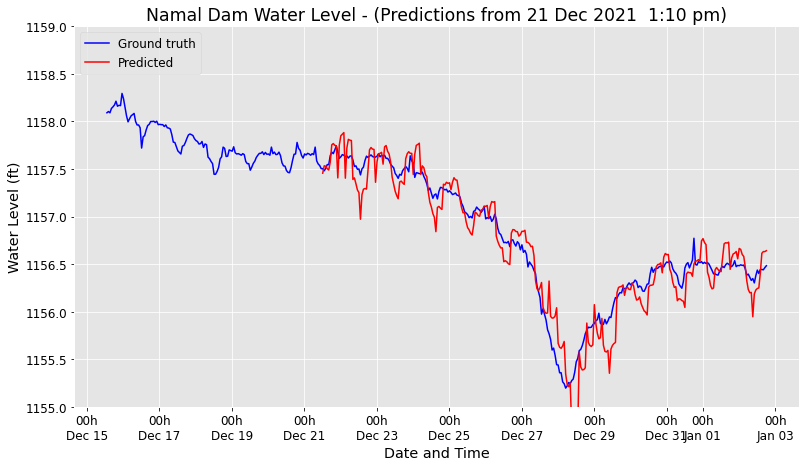

In [41]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(13,7 ))
ax.ticklabel_format(useOffset=False)

ax.plot(ground_date,Dataset2.iloc[:438]['Lake_water_level_in_ft'], label='Ground truth',color="b")

#ax.plot(w2, label='Real Water level',color="b")

ax.plot(prediction_date, pred_denorm3[:,0], label='Predicted',color="r")

ax.set_xlabel('Date and Time')
ax.set_ylim(1155, 1159)
ax.set_ylabel('Water Level (ft)')
ax.set_title('Namal Dam Water Level - (Predictions from 21 Dec 2021  1:10 pm)')
ax.grid(True)
ax.legend(loc='upper left')
date_form = DateFormatter("%Hh\n%b %d")
# \n%Y
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')
